In [3]:
# Import everything maybe needed somewhere
import matplotlib
from scipy import stats
import numpy as np
import pandas as pd
from scipy.io import loadmat
import scipy
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.interpolate import griddata
import os, glob, csv, shutil, sys
sns.set_style("white")
# %matplotlib inline

sys.path.append('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Code/Task')
from misc import idcs2state, state2idcs, get_new_state, get_a_opp, policy_choose, policy_choose_moves
from misc_analysis import get_optimal_move

In [4]:
# World 1
world1 = np.load('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/world1.npy')
world2 = np.load('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/world2.npy')
idcs1  = np.load('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/idcs1.npy')
idcs2  = np.load('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/idcs2.npy')

def idcs2state(idcs: list, states):
    '''Convert state idcs to state id'''
    si = idcs[0]
    sj = idcs[1]
    
    return states[si, sj]

def state2idcs(s: int, states):
    '''Convert state id to state idcs'''
    return np.argwhere(s == states)[0]

def get_new_state(si, a, world, states):
    '''Get new state from current state and action'''
    i_coord = si[0]
    j_coord = si[1]
    s1i = []
    
    side_i = world.shape[0]
    side_j = world.shape[1]
        
    cond1 = (i_coord == 0 and a == 0)          # top row, move up
    cond2 = (i_coord == (side_i-1) and a == 1) # bottom row, move down
    cond3 = (j_coord == 0 and a == 2)          # left column, move left
    cond4 = (j_coord == (side_j-1) and a == 3) # right column, move right
    
    if cond1:
        s1i = [side_i-1, j_coord]
    elif cond2:
        s1i = [0, j_coord]
    elif cond3:
        s1i = [i_coord, side_j-1]
    elif cond4:
        s1i = [i_coord, 0]
    else:
        if a == 0:   # up
            s1i = [i_coord-1, j_coord]
        elif a == 1: # down
            s1i = [i_coord+1, j_coord]
        elif a == 2: # left
            s1i = [i_coord, j_coord-1]
        else:        # right
            s1i = [i_coord, j_coord+1]

    s = idcs2state(s1i, states)
    r = world.ravel()[s]
    
    return s1i, r

def get_a_opp(a):
    
    if a == 0:
        a_opp = 1
    elif a == 1:
        a_opp = 0
    elif a == 2:
        a_opp = 3
    else:
        a_opp = 2
    
    return a_opp

def get_Q_true(world, state_arr):
    
    idcs = []
    for ai in [0, 1]:
        for aj in [0, 1]:
            idcs.append(ai*4+aj)
    for ai in [2, 3]:
        for aj in [2, 3]:
            ai_opp = get_a_opp(ai)
            if aj == ai_opp:
                idcs.append(ai*4+aj)
                    
    Q1_true = np.zeros((8,16))
    Q2_true = np.zeros((8,4))
    for s in range(8):
        si = state2idcs(s, state_arr)
        for a in range(4):
            s1i, r = get_new_state(si, a, world, state_arr)
            s1 = idcs2state(s1i, state_arr)
            Q2_true[s, a] = r

            for a2 in range(4):
                s2i, r2 = get_new_state(s1i, a2, world, state_arr)
                Q1_true[s, a*4+a2] = r + r2
        Q1_true[:, idcs] = np.nan
        
    return Q1_true, Q2_true

def policy_choose(q_values, temp, biases=None):
    '''Choose an action'''
    q_vals = q_values.copy()
    
    if biases is not None:
        num = q_vals*temp + biases
    else:
        num = q_vals*temp
    
    num = np.exp(num - np.nanmax(num))
    den = np.nansum(num)
    pol_vals = num/den
    
    pol_vals[np.isnan(pol_vals)] = 0
    
    if pol_vals.sum() == 0:
        return np.repeat(1/len(q_vals), len(q_vals))
    
    return pol_vals/pol_vals.sum()

def policy_choose_moves(Q, temp, biases):
    '''Choose an action'''
    q_vals1 = Q[0].copy()
    temp1   = temp[0]
    
    q_vals2 = Q[1].copy()
    temp2   = temp[1]
    
    num = q_vals1*temp1 + q_vals2*temp2 + biases
    
    num = np.exp(num - np.nanmax(num))
    den = np.nansum(num)
    pol_vals = num/den
    
    pol_vals[np.isnan(pol_vals)] = 0
    
    if pol_vals.sum() == 0:
        return np.repeat(1/len(q_vals2), len(q_vals2))
    
    return pol_vals/pol_vals.sum()

def get_entropy(T, s, a):
    
    out = 0
    for i in np.delete(range(8), s):
        out -= T[s, a, i]*np.log2(T[s, a, i])
    return out

def get_joint_entropy(T, s1, a1, a2):
    
    out = 0
    for i in np.delete(range(8), s1):
        
        probas = T[i, a2, :].copy()
        probas[s1] = 0
        probas = probas / np.sum(probas)
        for j in np.delete(range(8), [s1, i]):
            out -= T[s1, a1, i]*probas[j]*np.log2(T[s1, a1, i]*probas[j])
            
    return out
            
def policy_improve(q_before, q_after, Q_true, s, beta, biases, world, idcs, mode='value'):
    
    probs_before = policy_choose(q_before, beta, biases)
    probs_after  = policy_choose(q_after, beta, biases)
    
    if mode != 'value':
        a_opt = get_optimal_move(s, Q_true)

        opt = 0
        if len(a_opt) > 1:
            for a in a_opt:
                diff = probs_after[a] - probs_before[a]
                opt += diff
        else:
            opt = probs_after[a_opt] - probs_before[a_opt]
            
        out = opt*100
    
    else:
#         r = np.empty(0)
#         si = state2idcs(s, idcs)
#         for a in range(4):
#             _, ri = get_new_state(si, a, world, idcs)
#             r = np.append(r, ri)
#         out = np.sum(r*probs_after) - np.sum(r*probs_before)
        out = np.sum(q_after*probs_after) - np.sum(q_after*probs_before)
    
    return out

def policy_improve_2moves(q1_before, q1_after, q2_before, q2_after, Q1_true, s, beta1, beta2, biases, world, idcs, mode='value'):
    
    q_vals1 = np.zeros(4)
    for i in range(4):
        tmp     = q1_before[(i*4):(i*4+4)].copy()
        probs   = policy_choose(tmp, beta1, biases)
        q_vals1[i] = np.nansum(tmp*probs)
    q_vals2 = q2_before.copy()

    probs_before = policy_choose_moves([q_vals1, q_vals2], [beta1, beta2], biases)
    
    q_vals1 = np.zeros(4)
    for i in range(4):
        tmp     = q1_after[(i*4):(i*4+4)].copy()
        probs   = policy_choose(tmp, beta1, biases)
        q_vals1[i] = np.nansum(tmp*probs)
    q_vals2 = q2_after.copy()

    probs_after = policy_choose_moves([q_vals1, q_vals2], [beta1, beta2], biases)
    
    if mode != 'value':
        a_opt = get_optimal_move(s, Q1_true)//4

        opt = 0
        if len(a_opt) > 1:
            for a in a_opt:
                diff = probs_after[a] - probs_before[a]
                opt += diff
        else:
            opt = probs_after[a_opt] - probs_before[a_opt]
        
        out = opt*100
    
    else:
        r = np.empty(0)
        si = state2idcs(s, idcs)
        for a in range(4):
            _, ri = get_new_state(si, a, world, idcs)
            r = np.append(r, ri)
        out = np.sum(r*probs_after) - np.sum(r*probs_before)
    
    return out

def histogram(arr, bins=None):

    arr  = np.array(arr)
    arr  = arr[~np.isnan(arr)]
    if bins is not None:
        h, b = np.histogram(arr, bins=bins)
    else:
        h, b = np.histogram(arr, bins=range(0,int(np.max(arr)+2)))
    h    = h/np.sum(h)
    w    = b[1] - b[0]
    
    return h, b[:-1], w

def run_permutation_test(pooled, nx, ny, rep=False):

    shuffled = np.random.permutation(pooled)
    shuffX   = np.random.choice(shuffled, size=nx, replace=rep)
    shuffY   = np.random.choice(shuffled, size=ny, replace=rep)
    
    return np.mean(shuffX) - np.mean(shuffY)
    
def permutation_test(X, Y, num_perm, rep=False):
    
    X = np.array(X)
    X = X[~np.isnan(X)]

    Y = np.array(Y)
    Y = Y[~np.isnan(Y)]

    pooled = np.hstack([X,Y])
    
    delta  =  np.mean(X) - np.mean(Y)
    
    tests  = []
    for i in range(num_perm):
        tests += [run_permutation_test(pooled,len(X),len(Y), rep)]
        
    diff_count = len(np.where(tests >= delta)[0])
    p_value    = 1.0 - (float(diff_count)/float(num_perm))
    
    return delta, p_value

def get_sorted_files(path):
    
    os.chdir(path)
    all_files = glob.glob('*.npz')
    # Sort files by episode number
    episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
    idcs_ep  = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
    all_files_sorted = [all_files[i] for i in idcs_ep] 
    
    return all_files_sorted

### Single subject fit

In [8]:
def plot_performance(perf_agent, perf_human):
    
    fig = plt.figure(figsize=(7, 4), dpi=200)
    
    for i in range(0, 15, 3):
        if i == 12:
            plt.scatter(np.arange(3)+i, perf_agent[i:i+3], c='b', label='Agent')
            plt.scatter(np.arange(3)+i, perf_true[i:i+3], c='r', label='Human')
        else:
            plt.scatter(np.arange(3)+i, perf_agent[i:i+3], c='b')
            plt.scatter(np.arange(3)+i, perf_true[i:i+3], c='r')

    plt.axvline(2.5, linestyle='--')
    plt.axvline(5.5, linestyle='--', color='g', label='Rearrangement')
    plt.axvline(8.5, linestyle='--')
    plt.axvline(11.5, linestyle='--', color='r', label='World change')

    plt.legend(prop={'size': 6}, loc='best')
    plt.grid(alpha=0.5)
    plt.ylim([0, 1])
    plt.ylabel('Prop of available reward collected')
    plt.xlabel('Epochs')

    err = np.sqrt(np.sum(np.power((np.array(perf_true) - np.array(perf_agent)), 2)))
    plt.title('Performance, err = %.3f'%err)

    return fig

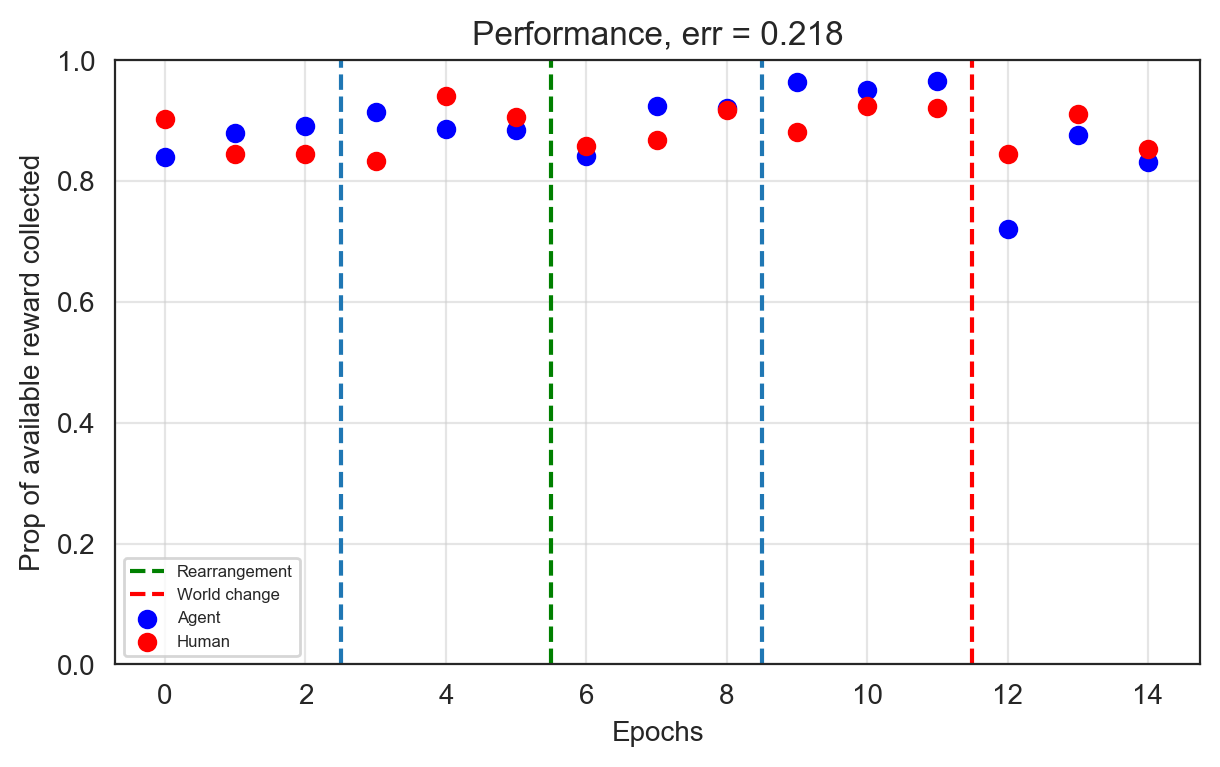

In [9]:
path = os.path.join('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/Eran/subject_data')

for sub in [0]:
    
    sub_path       = os.path.join(path, str(sub))
    
    blocks_max_rwd = np.load(os.path.join(sub_path, 'blocks_max_rwd.npy'), allow_pickle=True)[7:]
    blocks_obt_rwd = np.load(os.path.join(sub_path, 'blocks_obt_rwd.npy'), allow_pickle=True)[7:]
    blocks_loc     = np.load(os.path.join(sub_path, 'blocks_loc.npy'),     allow_pickle=True)[7:]

    perf_agent = []
    perf_true  = []
    rwd_obt    = []

    root_folder = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/Eran/task_recov/%u'%sub
    for i in range(5):
        if i == 0:
            this_range = 6
        else:
            this_range = 7
        tmp = []
        for j in range(this_range):
            os.chdir(os.path.join(root_folder, str(i), str(j)))
            all_files = glob.glob('*.npz')
            # Sort files by episode number
            episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
            idcs     = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
            all_files_sorted = [all_files[i] for i in idcs] 
            for f in range(len(all_files_sorted)):
                this_file = all_files_sorted[f]
                data      = np.load(this_file)
                move = data['move']
                if len(move) != 2:
                    r = move[2]
                    tmp.append(r)
                else:
                    move1 = move[0]
                    move2 = move[1]
                    tmp.append(move1[2]+move2[2])
        rwd_obt.append(tmp)

    for i in range(5):
        for j in range(0, 54, 18):
            perf_agent.append((np.sum(rwd_obt[i][j:j+18])/np.sum(blocks_max_rwd[i][j:j+18])))
            perf_true.append((np.sum(blocks_obt_rwd[i][j:j+18])/np.sum(blocks_max_rwd[i][j:j+18])))
    
    fig = plot_performance(perf_agent, perf_true)

#     plt.savefig(os.path.join(root_folder, 'performance.png'))
#     plt.close()

### Overall fit

In [ ]:
path        = '/Users/GA/Documents/Dayan_lab/Data/Eran/subject_data'
task_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/task'

nsubs = 40

perf_agent  = np.zeros((nsubs, 15))
perf_human  = np.zeros((nsubs, 15))

for sub in range(nsubs):

    sub_path       = os.path.join(path, str(sub))

    blocks_max_rwd = np.load(os.path.join(sub_path, 'blocks_max_rwd.npy'), allow_pickle=True)[7:]
    blocks_obt_rwd = np.load(os.path.join(sub_path, 'blocks_obt_rwd.npy'), allow_pickle=True)[7:]

    rwd_obt    = []

    sub_task_folder = os.path.join(task_folder, str(sub))
    for i in range(5):
        if i == 0:
            this_range = 6
        else:
            this_range = 7
        tmp = []
        for j in range(this_range):
            # Prepare to load files
            epoch_folder = os.path.join(sub_task_folder, str(i), str(j))
            all_files_sorted = get_sorted_files(epoch_folder)

            for f in range(len(all_files_sorted)):
                this_file      = all_files_sorted[f]
                data      = np.load(os.path.join(epoch_folder, this_file), allow_pickle=True)
                move = data['move']
                if len(move) != 2:
                    r = move[2]
                    tmp.append(r)
                else:
                    move1 = move[0]
                    move2 = move[1]
                    tmp.append(move1[2]+move2[2])
        rwd_obt.append(tmp)

    count = 0
    for i in range(5):
        for j in range(0, 54, 18):
            ag = np.sum(rwd_obt[i][j:j+18])/np.sum(blocks_max_rwd[i][j:j+18])
            hm = np.sum(blocks_obt_rwd[i][j:j+18])/np.sum(blocks_max_rwd[i][j:j+18])

            perf_agent[sub, count] = ag
            perf_human[sub, count] = hm

            count += 1

In [ ]:
fig = plt.figure(figsize=(14, 7))
for i in range(1, 16, 3):
    y_h = perf_human[:, i-1:i+2]
    y_h_plot = np.mean(y_h, axis=0)
    
    y_a = perf_agent[:, i-1:i+2]
    y_a_plot = np.mean(y_a, axis=0)
    
    x = np.arange(i,i+3)
    
    std_h = np.std(y_h, axis=0)
    sem_h = std_h/np.sqrt(40)
    
    std_a = np.std(y_a, axis=0)
    sem_a = std_a/np.sqrt(40)
    
    plt.plot(x, y_h_plot, c='k', linewidth=5)
    plt.fill_between(x, (y_h_plot-sem_h), (y_h_plot+sem_h), color='k', alpha=.2)
    
    plt.plot(x, y_a_plot, c='#00D667', linewidth=2)
    
plt.scatter(range(1,16), np.mean(perf_human, axis=0), label='Humans', c='k', marker='h', s=300)
plt.scatter(range(1,16), np.mean(perf_agent, axis=0), label='Agent', c='#00D667', marker='h', s=100)
plt.ylim([.58,.82])
plt.legend()

# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure1/overall_fit.svg', format='svg', transparent=True)

In [ ]:
data_path = os.path.join('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure1', 'panel_3c.mat')
data      = loadmat(data_path)

In [ ]:
high_seq = [data['first_of_two_moves_high_seq'], data['second_of_two_moves_high_seq'], data['one_move_high_seq']]
low_seq = [data['first_of_two_moves_low_seq'], data['second_of_two_moves_low_seq'], data['one_move_low_seq']]

In [ ]:
fig = plt.figure(figsize=(5, 5))

c = 0
colours = ['k', 'r', 'b']
labels  = ['first', 'second', 'one']
for i in range(3):
    y = low_seq[i]
    plt.scatter(1+c, np.mean(y), marker='h', c=colours[i], s=150, label=labels[i])
    std = np.std(y, axis=0)
    sem = std/np.sqrt(len(y))
    plt.plot([1+c, 1+c], [np.mean(y)-sem, np.mean(y)+sem], c=colours[i])
    
    y = high_seq[i]
    plt.scatter(2+c, np.mean(y), marker='h', c=colours[i], s=150)
    std = np.std(y, axis=0)
    sem = std/np.sqrt(len(y))
    plt.plot([2+c, 2+c], [np.mean(y)-sem, np.mean(y)+sem], c=colours[i])
    c += 0.18

plt.legend(prop={'size':13})
plt.xlim(0.36, 3)
plt.ylim(-0.06, 0.06)
plt.yticks([-0.05, 0, 0.05], [-5, 0, 5], fontsize=16);
plt.xticks([1.18, 2.18], ['low', 'high'], fontsize=16);

plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure1/panel_3c.svg', format='svg', transparent=True)

### Flexibility

In [ ]:
k = np.zeros((40, 4))

for sub in range(40):

    root_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/%u'%(sub)
    
    opt_moves11 = 0
    opt_moves12 = 0
    opt_moves21 = 0
    opt_moves22 = 0
    
    # iterate over 5 blocks
    for i in range(5):
        if i == 0:
            this_range = 6
        else:
            this_range = 7
        tmp = []
        
        if i in [0, 1]:
            Q1_true, Q2_true = get_Q_true(world1, idcs1)
        elif i in [2, 3]:
            Q1_true, Q2_true = get_Q_true(world2, idcs1)
        else:
            Q1_true, Q2_true = get_Q_true(world2, idcs2)
        
        for j in range(this_range):
    
            os.chdir(os.path.join(root_folder, str(i), str(j)))
            all_files = glob.glob('*.npz')

            # Sort files by episode number
            episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
            idcs     = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
            all_files_sorted = [all_files[i] for i in idcs] 
            
            for f in range(len(all_files_sorted)):
                this_file = all_files_sorted[f]
                data      = np.load(this_file)
                move      = data['move']
                
                if len(move) != 2:
                    s = move[0]
                    a = move[1]
                    if a in get_optimal_move(s, Q2_true):
                        opt_moves11 += 1
                    elif a in get_optimal_move(s, Q1_true)//4:
                        opt_moves12 += 1

                else:
                    s = move[0][0]
                    a = move[0][1]
                    if a in get_optimal_move(s, Q2_true):
                        opt_moves21 += 1
                    elif a in get_optimal_move(s, Q1_true)//4:
                        opt_moves22 += 1
    
    k[sub, :] = [opt_moves11/(18*5), opt_moves12/(18*5), opt_moves21/(36*5), opt_moves22/(36*5)]

In [ ]:
path = '/Users/GA/Documents/Dayan_lab/Data/Eran/PerformanceSummaries.mat'
data = loadmat(path)

figure = plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

flex_idcs_hums = []
for i in range(40):
    tmp = np.mean(data['Fig1d'][i, :, :], axis=1)
    flex_idcs_hums.append(tmp[0]-tmp[1]+tmp[3]-tmp[2])
    plt.scatter([1, 2, 3, 4], tmp)
    plt.plot([1, 2], [tmp[0], tmp[1]])
    plt.plot([3, 4], [tmp[2], tmp[3]])
plt.axhline(0.33, c='k', linestyle='--')
plt.ylim([0,1])
plt.title('Humans', fontsize=14)
del data

plt.subplot(1, 2, 2)

flex_idcs_ag = []
for i in range(40):
    flex_idcs_ag.append(k[i, 0]-k[i, 1]+k[i, 3]-k[i, 2])
    plt.scatter([1, 2, 3, 4], k[i, :])
    plt.plot([1, 2], [k[i, 0], k[i, 1]])
    plt.plot([3, 4], [k[i, 2], k[i, 3]])
plt.axhline(0.33, c='k', linestyle='--')
plt.ylim([0,1])
plt.title('Agent', fontsize=14)

In [ ]:
figure = plt.figure(figsize=(6, 6))

reg = LinearRegression().fit(np.array(flex_idcs_hums).reshape(-1, 1), np.array(flex_idcs_ag).reshape(-1,1))

x_pred = np.linspace(-0.15, 1.2, 20)
y_pred = reg.predict(x_pred.reshape(-1, 1))
r, p = scipy.stats.pearsonr(flex_idcs_hums, flex_idcs_ag)

plt.scatter(flex_idcs_hums, flex_idcs_ag, c='k')
plt.plot(x_pred, y_pred, c='r')
plt.xlabel('Human IF', fontsize=14)
plt.ylabel('Agent IF', fontsize=14)
plt.title(r'$R^{2}=%.2f, p=%.3E$'%(r**2, p));

### Save params

In [5]:
root = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/Eran/fits_recov/'

In [6]:
e = []
for i in range(40):
    for j in range(10):
        try:
            df = pd.read_csv(os.path.join(root, 'save_params_%u'%i, str(j), 'backup.txt'), header=None, sep='\t', index_col=False, skiprows=1)
            np.save(os.path.join(root, 'save_params_%u'%i, str(j), 'params.npy'), df.iloc[-1].values[:18])
            e.append(df.iloc[-1].values[18])
        except:
            print(i)

0
1
1
2
2
2
2
3
6
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
25
25
26
26
26
26
26
26
26
26
26
26
27
27
27
27
27
27
27
27
27
27
28
28
28
28
28
28
28
28
28
28
29
29
29
29
29
29
29
29
29
29
30
30
30
30
30
30
30
30
30
30
31
31
31
31
31
31
31
31
31
31
32
32
32
32
32
32
32
32
32
32
33
33
33
33
33
33
33
33
33
33
34
34
34
34
34
34
34
34
34
34
35
35
35
35
35
35
35
35
35
35
36
36
36
36
36
36
36
36
36
36
37
37
37
37
37
37
37
37
37
37
38
38
38
38
38
38
38
38
38
38
39
39
39
39
39
39
39
39
39
39


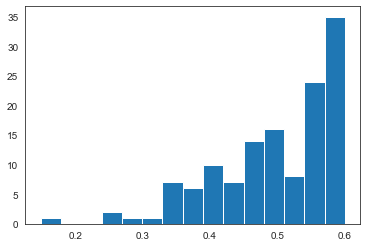

In [7]:
plt.hist(e, bins=15);
# plt.savefig(os.path.join(root, 'final_errors.svg'), transparent=True)

### Analyse replays of just-taken transitions

In [17]:
root_folder   = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/task'

for sub in [16]:
        
    H_opt_single    = []
    H_opt_paired    = []
    H_subopt_single = []
    H_subopt_paired = []
    opt             = []
    subopt          = []

    sub_task_folder = os.path.join(root_folder, str(sub))

    for i in range(5):
        if i == 0:
            this_range = 6
        else:
            this_range = 7

        if i in [0, 1]:
            Q1_true, Q2_true = get_Q_true(world1, idcs1)
        elif i in [2, 3]:
            Q1_true, Q2_true = get_Q_true(world2, idcs1)
        else:
            Q1_true, Q2_true = get_Q_true(world2, idcs2)

        for j in range(this_range):
            if i > 0 and j < 2:
                pass
            else:
                # Prepare to load files
                epoch_folder = os.path.join(sub_task_folder, str(i), str(j))
                all_files_sorted = get_sorted_files(epoch_folder)

                for f in range(len(all_files_sorted)):

                    this_file = all_files_sorted[f]
                    data      = np.load(os.path.join(epoch_folder, this_file), allow_pickle=True)
                    move      = data['move']
                    T         = data['T']
                    replay_backups = np.atleast_2d(data['replay_backups'])

                    if len(move) == 2:

                        s1 = move[0][0]
                        a1 = move[0][1]

                        s2 = move[1][0]
                        a2 = move[1][1]

                        a  = a1*4 + a2

                        paired_move_optimal        = a  in get_optimal_move(s1, Q1_true)
                        second_single_move_optimal = a2 in get_optimal_move(s2, Q2_true)

                        # up/down replays correspond to the same 'experience' – pool these together
                        ja  = [a1*4 + a2]
                        ja1 = [a1]
                        ja2 = [a2]
                        if a1 in [0, 1]:
                            ja  = [a1*4 + a2, (1-a1)*4 + a2] # up (0) /down (1) + second move
                            ja1 = [a1, (1-a1)]
                        if a2 in [0, 1]:
                            ja  = [a1*4 + a2, a1*4+ (1-a2)] # first move + up (0) /down (1)
                            ja2 = [a2, (1-a2)] # up (0) /down (1) in the second move

                        if replay_backups.shape[0] > 1:

                            idcs_paired_similar = []
                            idcs_single_similar = []

                            # Find replays of the paired move
                            s_cond      = replay_backups[:, 0] == s1
                            a_cond      = (replay_backups[:, 1] == ja[0])
                            p_cond      = (replay_backups[:, 4] == 0)
                            idcs_paired = np.argwhere(s_cond & a_cond & p_cond).flatten()
                            if len(ja) > 1:
                                a_cond_similar      = (replay_backups[:, 1] == ja[1])
                                idcs_paired_similar = np.argwhere(s_cond & a_cond_similar & p_cond).flatten()

                            # Find replays of the second move
                            # NB replays of the first move are not included since optimal first moves in 
                            # 2-move trials are usually not the same as optimal moves in 1-move trials
                            s_cond = replay_backups[:, 0] == s2
                            a_cond = (replay_backups[:, 1] == ja2[0])
                            p_cond = (replay_backups[:, 4] == 1)
                            idcs_single = np.argwhere(s_cond & a_cond & p_cond).flatten()
                            if len(ja2) > 1:
                                a_cond_similar      = (replay_backups[:, 1] == ja2[1])
                                idcs_single_similar = np.argwhere(s_cond & a_cond_similar & p_cond).flatten()

                            num_paired         = len(idcs_paired)
                            num_paired_similar = len(idcs_paired_similar)
                            num_single         = len(idcs_single)
                            num_single_similar = len(idcs_single_similar)

                            # If the sequence was optimal, then both the sequence and the 
                            # second move were optimal
                            if paired_move_optimal:

                                opt += [num_paired + num_single + num_paired_similar + num_single_similar]

                                if num_paired > 0:
                                    H_opt_paired += [get_joint_entropy(T, s1, ja[0]//4, ja[0]%4)]*num_paired
                                if num_paired_similar > 0:
                                    H_opt_paired += [get_joint_entropy(T, s1, ja[1]//4, ja[1]%4)]*num_paired_similar

                                if num_single > 0:
                                    H_opt_single += [get_entropy(T, s2, ja2[0])]*num_single
                                if num_single_similar > 0:
                                    H_opt_single += [get_entropy(T, s2, ja2[1])]*num_single_similar

                            # If the sequence was sub-optimal that could be due to the 
                            # first move. The second move can still be optimal
                            if second_single_move_optimal and not paired_move_optimal:

                                # Second move thus optimal
                                opt    += [num_single + num_single_similar]
                                if num_single > 0:
                                    H_opt_single += [get_entropy(T, s2, ja2[0])]*num_single
                                if num_single_similar > 0:
                                    H_opt_single += [get_entropy(T, s2, ja2[1])]*num_single_similar

                                # Sequence sub-optimal
                                subopt += [num_paired + num_paired_similar]
                                if num_paired > 0:
                                    H_subopt_paired += [get_joint_entropy(T, s1, ja[0]//4, ja[0]%4)]*num_paired
                                if num_paired_similar > 0:
                                    H_subopt_paired += [get_joint_entropy(T, s1, ja[1]//4, ja[1]%4)]*num_paired_similar

                            # If the subject screwed up everything
                            if not second_single_move_optimal and not paired_move_optimal:

                                subopt += [num_paired + num_single + num_paired_similar + num_single_similar]

                                if num_paired > 0:
                                    H_subopt_paired += [get_joint_entropy(T, s1, ja[0]//4, ja[0]%4)]*num_paired
                                if num_paired_similar > 0:
                                    H_subopt_paired += [get_joint_entropy(T, s1, ja[1]//4, ja[1]%4)]*num_paired_similar

                                if num_single > 0:
                                    H_subopt_single += [get_entropy(T, s2, ja2[0])]*num_single
                                if num_single_similar > 0:
                                    H_subopt_single += [get_entropy(T, s2, ja2[1])]*num_single_similar

                        else:
                            if paired_move_optimal:
                                opt    += [0]
                            else:
                                subopt += [0]

                    else:
                        s2 = move[0]
                        a2 = move[1]
                        single_move_optimal = a2 in get_optimal_move(s2, Q2_true)

                        ja2 = [a2]
                        if a2 in [0, 1]:
                            ja2 = [a2, (1-a2)]

                        if replay_backups.shape[0] > 1:

                            idcs_single_similar = []

                            s_cond      = replay_backups[:, 0] == s2
                            a_cond      = replay_backups[:, 1] == ja2[0]
                            idcs_single = np.argwhere(s_cond & a_cond).flatten()
                            if len(ja2) > 1:
                                a_cond_similar      = (replay_backups[:, 1] == ja2[1])
                                idcs_single_similar = np.argwhere(s_cond & a_cond_similar).flatten()

                            num_replays = len(idcs_single)
                            num_replays_similar = len(idcs_single_similar)

                            if single_move_optimal:

                                opt   += [num_replays + num_replays_similar]
                                if num_replays > 0:
                                    H_opt_single += [get_entropy(T, s2, ja2[0])]*num_replays
                                if num_replays_similar > 0:
                                    H_opt_single += [get_entropy(T, s2, ja2[1])]*num_replays_similar

                            else:
                                subopt   += [num_replays + num_replays_similar]
                                if num_replays > 0:
                                    H_subopt_single += [get_entropy(T, s2, ja2[0])]*num_replays
                                if num_replays_similar > 0:
                                    H_subopt_single += [get_entropy(T, s2, ja2[1])]*num_replays_similar

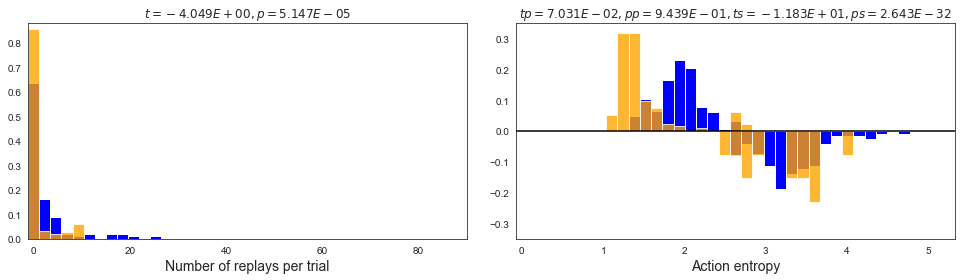

In [18]:
plt.figure(figsize=(14, 4))

# Replays
plt.subplot(1, 2, 1)
bins = np.linspace(0, 90, 40)
subopt_h, subopt_b, subopt_w = histogram(subopt, bins)
plt.bar(subopt_b, subopt_h, width=subopt_w, facecolor='b')
opt_h, opt_b, subopt_w = histogram(opt, bins)
plt.bar(opt_b, opt_h, width=subopt_w, facecolor='orange', alpha=0.8)
plt.xlabel('Number of replays per trial', fontsize=14)
plt.xlim(0-subopt_w/2, 90)
# plt.xticks(np.arange(0, 40, 5), np.arange(0, 40, 5), fontsize=10)
t, p = scipy.stats.ranksums(opt, subopt)
# t, p = permutation_test(opt, subopt, 100000)
plt.title(r'$t=%.3E, p=%.3E$'%(t, p));
plt.ylim(0, 0.88)

# Single entropy
plt.subplot(1, 2, 2)
bins=np.linspace(0, np.log2(7)+np.log2(6), 40)
H_subopt_h, H_subopt_b, H_subopt_w = histogram(H_subopt_single, bins)
plt.bar(H_subopt_b, H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_single, bins)
plt.bar(H_opt_b, H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)
plt.xlim(0-H_subopt_w/2, np.log2(7)+np.log2(6)-H_subopt_w/2)

# Paired entropy
H_subopt_h, H_subopt_b, _ = histogram(H_subopt_paired, bins)
plt.bar(H_subopt_b, -H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_paired, bins)
plt.bar(H_opt_b, -H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)
# plt.axvline(np.log2(7)+H_subopt_w/4)

plt.ylim(-0.35, 0.35)
plt.axhline(0, c='k')
plt.xlabel('Action entropy', fontsize=14)
ts, ps = scipy.stats.ranksums(H_opt_single, H_subopt_single)
tp, pp = scipy.stats.ranksums(H_opt_paired, H_subopt_paired)
# ts, ps = permutation_test(H_opt_single, H_subopt_single, 100000)
# tp, pp = permutation_test(H_opt_paired, H_subopt_paired, 100000)
plt.title(r'$tp=%.3E, pp=%.3E, ts=%.3E, ps=%.3E$'%(tp, pp, ts, ps));
plt.tight_layout()
# 
plt.savefig('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Paper/Figures_data/supp9/recent_replays.svg', format='svg', transparent=True)

In [10]:
H_opt_paired_exp    = H_opt_paired.copy()
H_subopt_paired_exp = H_subopt_paired.copy()
H_opt_single_exp    = H_opt_single.copy()
H_subopt_single_exp = H_subopt_single.copy()

opt_all_exp    = opt.copy()
subopt_all_exp = subopt.copy()

opt_single vs subopt_single: t=-5.463E+00, p=4.682E-08
opt_paired vs subopt_paired: t=-3.176E+00, p=1.495E-03


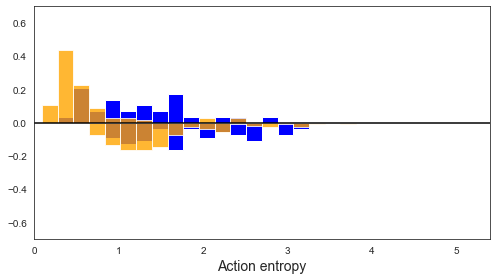

In [6]:
plt.figure(figsize=(7, 4))

bins=np.linspace(0, np.log2(7)+np.log2(6), 30)
H_subopt_h, H_subopt_b, H_subopt_w = histogram(H_subopt_single_all, bins)
plt.bar(H_subopt_b, H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_single_all, bins)
plt.bar(H_opt_b, H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)

# Paired entropy
H_subopt_h, H_subopt_b, _ = histogram(H_subopt_paired_all, bins)
plt.bar(H_subopt_b, -H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_paired_all, bins)
plt.bar(H_opt_b, -H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)

plt.axhline(0, c='k')
plt.ylim(-0.7, 0.7)
plt.xlim(0, np.log2(7) + np.log2(6))
plt.xlabel('Action entropy', fontsize=14)
ts, ps = scipy.stats.ranksums(H_opt_single_all, H_subopt_single_all)
print('opt_single vs subopt_single: t=%.3E, p=%.3E'%(ts, ps))

tp, pp = scipy.stats.ranksums(H_opt_paired_all, H_subopt_paired_all)
print('opt_paired vs subopt_paired: t=%.3E, p=%.3E'%(tp, pp))
plt.tight_layout()

# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure6/just_taken_entropy.svg', format='svg', transparent=True)

In [ ]:
plt.figure(figsize=(4, 4))

plt.bar(1, np.mean(opt_all), facecolor='orange', alpha=0.6, align='center')
plt.scatter([1]*len(opt_all), opt_all, c='orange')
plt.bar(2, np.mean(subopt_all), facecolor='b', alpha=0.6, align='center')
plt.scatter([2]*len(subopt_all), subopt_all, c='b')
plt.axhline(0, c='k')

t, p = permutation_test(opt_all, subopt_all, 100000)
print('opt vs subopt: t=%.3E, p=%.3E'%(t, p))
# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure6/just_taken_replays.svg', format='svg', transparent=True)

In [ ]:
len(subs_who_replay)

### Analyse replays of other transitions

In [11]:
root_folder   = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/task'

for sub in [16]:
        
    H_opt_single    = []
    H_opt_paired    = []
    H_subopt_single = []
    H_subopt_paired = []
    opt             = []
    subopt          = []

    sub_task_folder = os.path.join(root_folder, str(sub))

    for i in range(5):
        if i == 0:
            this_range = 6
        else:
            this_range = 7

        if i in [0, 1]:
            Q1_true, Q2_true = get_Q_true(world1, idcs1)
        elif i in [2, 3]:
            Q1_true, Q2_true = get_Q_true(world2, idcs1)
        else:
            Q1_true, Q2_true = get_Q_true(world2, idcs2)

        for j in range(this_range):
            if i > 0 and j < 2:
                pass
            else:
                # Prepare to load files
                epoch_folder = os.path.join(sub_task_folder, str(i), str(j))
                all_files_sorted = get_sorted_files(epoch_folder)

                for f in range(len(all_files_sorted)):

                    tmp_opt = 0
                    tmp_subopt = 0

                    this_file = all_files_sorted[f]
                    data      = np.load(os.path.join(epoch_folder, this_file), allow_pickle=True)
                    move      = data['move']
                    T         = data['T']

                    replay_backups = np.atleast_2d(data['replay_backups'])
                    if replay_backups.shape[0] > 1:

                        if len(move) == 2:

                            s1 = move[0][0]
                            a1 = move[0][1]

                            s2 = move[1][0]
                            a2 = move[1][1]

                            a  = a1*4 + a2

                            # Ditto
                            ja  = [a1*4 + a2]
                            ja1 = [a1]
                            ja2 = [a2]
                            if a1 in [0, 1]:
                                ja  = [a1*4 + a2, (1-a1)*4 + a2] # up (0) /down (1) + second move
                                ja1 = [a1, (1-a1)]
                            if a2 in [0, 1]:
                                ja  = [a1*4 + a2, a1*4+ (1-a2)] # first move + up (0) /down (1)
                                ja2 = [a2, (1-a2)] # up (0) /down (1) in the second move

                            for rid in range(replay_backups.shape[0]):

                                this_replay = replay_backups[rid, :]
                                sr = int(this_replay[0])
                                ar = int(this_replay[1])
                                pl = int(this_replay[4])

                                if sr != -200 and ar != -200:

                                    if pl == 0:
                                        if sr != s1 and ar not in ja:
                                            paired_move_optimal = ar in get_optimal_move(sr, Q1_true)
                                            if paired_move_optimal:
                                                H_opt_paired += [get_joint_entropy(T, sr, ar//4, ar%4)]
                                                tmp_opt += 1
                                            else:
                                                H_subopt_paired += [get_joint_entropy(T, sr, ar//4, ar%4)]
                                                tmp_subopt += 1
                                    else:
                                        cond1 = sr != s1 and ar not in ja1
                                        cond2 = sr != s2 and ar not in ja2
                                        if cond1 and cond2:
                                            second_single_move_optimal = ar in get_optimal_move(sr, Q2_true)
                                            if second_single_move_optimal:
                                                H_opt_single += [get_entropy(T, sr, ar)]
                                                tmp_opt += 1
                                            else:
                                                H_subopt_single += [get_entropy(T, sr, ar)]
                                                tmp_subopt += 1
                        else:
                            s2 = move[0]
                            a2 = move[1]

                            ja2 = [a2]
                            if a2 in [0, 1]:
                                ja2 = [a2, (1-a2)]

                            replay_backups = np.atleast_2d(data['replay_backups'])
                            if replay_backups.shape[0] > 1:

                                for rid in range(replay_backups.shape[0]):
                                    this_replay = replay_backups[rid, :]
                                    sr = int(this_replay[0])
                                    ar = int(this_replay[1])

                                    if sr != -200 and ar != -200:

                                        if sr != s2 and ar not in ja2:
                                            single_move_optimal = ar in get_optimal_move(sr, Q2_true)

                                            if single_move_optimal:
                                                H_opt_single += [get_entropy(T, sr, ar)]
                                                tmp_opt += 1
                                            else:
                                                H_subopt_single += [get_entropy(T, sr, ar)]
                                                tmp_subopt += 1
                    else:
                        tmp_opt     = 0
                        tmp_subopt  = 0

                    opt    += [tmp_opt]
                    subopt += [tmp_subopt]

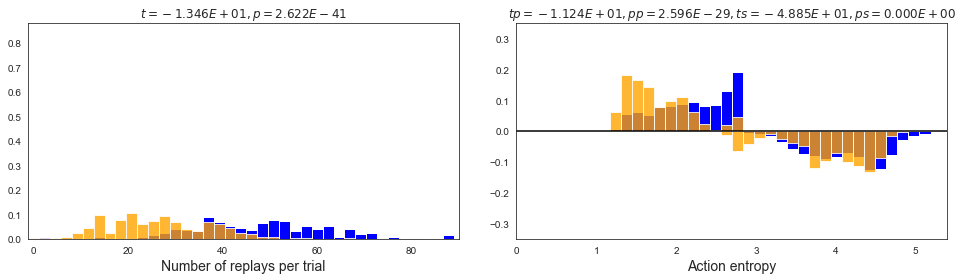

In [16]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
bins = np.linspace(0, 90, 40)
subopt_h, subopt_b, subopt_w = histogram(subopt, bins)
plt.bar(subopt_b, subopt_h, width=subopt_w, facecolor='b')
opt_h, opt_b, subopt_w = histogram(opt, bins)
plt.bar(opt_b, opt_h, width=subopt_w, facecolor='orange', alpha=0.8)
plt.xlabel('Number of replays per trial', fontsize=14)
plt.xlim(0-subopt_w/2, 90)
# plt.xticks(np.arange(0, 40, 5), np.arange(0, 40, 5), fontsize=10)
t, p = scipy.stats.ranksums(opt, subopt)
# t, p = permutation_test(opt, subopt, 100000)
plt.title(r'$t=%.3E, p=%.3E$'%(t, p));
plt.ylim(0, 0.88)

# Single entropy
plt.subplot(1, 2, 2)
bins=np.linspace(0, np.log2(7)+np.log2(6), 40)
H_subopt_h, H_subopt_b, H_subopt_w = histogram(H_subopt_single, bins)
plt.bar(H_subopt_b, H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_single, bins)
plt.bar(H_opt_b, H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)
plt.xlim(0-H_subopt_w/2, np.log2(7)+np.log2(6)+H_subopt_w/2)

# Paired entropy
H_subopt_h, H_subopt_b, _ = histogram(H_subopt_paired, bins)
plt.bar(H_subopt_b, -H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_paired, bins)
plt.bar(H_opt_b, -H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)

plt.ylim(-0.35, 0.35)
plt.axhline(0, c='k')
plt.xlabel('Action entropy', fontsize=14)
ts, ps = scipy.stats.ranksums(H_opt_single, H_subopt_single)
tp, pp = scipy.stats.ranksums(H_opt_paired, H_subopt_paired)
plt.title(r'$tp=%.3E, pp=%.3E, ts=%.3E, ps=%.3E$'%(tp, pp, ts, ps));
plt.tight_layout()

plt.xlim([0, np.log2(7)+np.log2(6)])

plt.savefig('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Paper/Figures_data/supp9/other_replays.svg', format='svg', transparent=True)

In [40]:
t, p_ent_opt = scipy.stats.ranksums(H_opt_paired_exp, H_opt_paired)
print('H_opt_paired_exp vs H_opt_paired:       t = %.3E, p = %.3E'%(t, p_ent_opt))
t, p_ent_opt = scipy.stats.ranksums(H_opt_single_exp, H_opt_single)
print('H_opt_single_exp vs H_opt_single:       t = %.3E, p = %.3E'%(t, p_ent_opt))
t, p_ent_subopt = scipy.stats.ranksums(H_subopt_paired_exp, H_subopt_paired)
print('H_subopt_paired_exp vs H_subopt_paired: t = %.3E, p = %.3E'%(t, p_ent_subopt))
t, p_ent_subopt = scipy.stats.ranksums(H_subopt_single_exp, H_subopt_single)
print('H_subopt_single_exp vs H_subopt_single: t = %.3E, p = %.3E'%(t, p_ent_subopt))

t, p_subopt = scipy.stats.ranksums(subopt_all_exp, subopt)
print('subopt_all_exp vs subopt_all: t = %.3E, p = %.3E'%(t, p_subopt))

t, p_opt = scipy.stats.ranksums(opt_all_exp, opt)
print('opt_all_exp vs opt_all:       t = %.3E, p = %.3E'%(t, p_opt))

H_opt_paired_exp vs H_opt_paired:       t = -4.130E+00, p = 3.633E-05
H_opt_single_exp vs H_opt_single:       t = -1.192E+01, p = 8.901E-33
H_subopt_paired_exp vs H_subopt_paired: t = -1.512E+01, p = 1.123E-51
H_subopt_single_exp vs H_subopt_single: t = -9.559E+00, p = 1.186E-21
subopt_all_exp vs subopt_all: t = -1.412E+01, p = 2.990E-45
opt_all_exp vs opt_all:       t = -1.619E+01, p = 5.827E-59


In [ ]:
plt.figure(figsize=(7, 4))

bins=np.linspace(0, np.log2(7)+np.log2(6), 30)
H_subopt_h, H_subopt_b, H_subopt_w = histogram(H_subopt_single, bins)
plt.bar(H_subopt_b, H_subopt_h, width=H_subopt_w, facecolor='b', align='center')
H_opt_h, H_opt_b, _ = histogram(H_opt_single, bins)
plt.bar(H_opt_b, H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)

# Paired entropy
H_subopt_h, H_subopt_b, _ = histogram(H_subopt_paired, bins)
plt.bar(H_subopt_b, -H_subopt_h, width=H_subopt_w, facecolor='b', align='center')
H_opt_h, H_opt_b, _ = histogram(H_opt_paired, bins)
plt.bar(H_opt_b, -H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)

plt.axhline(0, c='k')
plt.xlim(0, np.log2(7) + np.log2(6))
plt.ylim(-0.7, 0.7)
plt.xlabel('Action entropy', fontsize=14)
ts, ps = scipy.stats.ranksums(H_opt_single, H_subopt_single)
print('H_opt_single vs H_subopt_single: t=%.3E, p=%.3E'%(ts, ps))

tp, pp = scipy.stats.ranksums(H_opt_paired, H_subopt_paired)
print('H_opt_paired vs H_subopt_paired: t=%.3E, p=%.3E'%(tp, pp))
plt.tight_layout()

plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure6/all_entropy.svg', format='svg', transparent=True)

In [ ]:
plt.figure(figsize=(4, 4))

plt.bar(1, np.mean(opt_all), facecolor='orange', alpha=0.6, align='center')
plt.scatter([1]*len(opt_all), opt_all, c='orange')
plt.bar(2, np.mean(subopt_all), facecolor='b', alpha=0.6, align='center')
plt.scatter([2]*len(subopt_all), subopt_all, c='b')
plt.axhline(0, c='k')

t, p = scipy.stats.ranksums(opt_all, subopt_all)
print('opt vs subopt: t=%.3E, p=%.3E'%(t, p))
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure6/all_replays.svg', format='svg', transparent=True)

### Capture behaviour

In [ ]:
def convert_move(a):
    if np.isnan(a):
        pass
    elif a == 1:
        a = 2
    elif a == 2:
        a = 3
    elif a == 3:
        a = 0
    else:
        a = 1
    return a

In [ ]:
Q1_true, Q2_true = get_Q_true(world1, idcs1)

In [ ]:
data_path = os.path.join('/Users/GA/Documents/Dayan_lab/Data/Eran', 'Behavioral Data.mat')
root_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'
# sub = 17
sub = 19

data      = loadmat(data_path)
task_data = data['TSK'][0, sub]
choices   = []

# Convert squalid matlab into something humane
for i in range(7, 12):
    tmp = np.squeeze(task_data[0, i]['D']['choice'][0][0])
    choices.append([i.tolist()[0] for i in tmp.tolist()])

for i in range(len(choices)):
    block = choices[i]
    for j in range(len(block)):
        move = block[j]
        if len(move) == 1:
            move[0] = convert_move(move[0])
        else:
            for j1 in range(len(move)):
                move[j1] = convert_move(move[j1])
        block[j] = move
    choices[i] = block
        
            
del data

for i in range(5):
    if i == 0:
        this_range = 6
    else:
        this_range = 7
    
    if i in [0, 1]:
        Q1_true, Q2_true = get_Q_true(world1, idcs1)
    elif i in [2, 3]:
        Q1_true, Q2_true = get_Q_true(world2, idcs1)
    else:
        Q1_true, Q2_true = get_Q_true(world2, idcs2)
                
    c = 0
    for j in range(this_range):
        # Prepare to load files
        os.chdir(os.path.join(root_folder, str(sub), str(i), str(j)))
        all_files = glob.glob('*.npz')
        # Sort files by episode number
        episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
        idcs     = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
        all_files_sorted = [all_files[i] for i in idcs] 

        for f in range(len(all_files_sorted)):
            
            this_file = all_files_sorted[f]
            data      = np.load(this_file, allow_pickle=True)
            move      = data['move']
            if len(move) == 2:
                act_move  = choices[i][c]
                if np.isnan(act_move[0]):
                    pass
                else:
                    s = move[0, 0]
                    a = move[0, 1]
                    s1 = move[1, 0]
                    a1 = move[1, 1]

                    if np.array_equal([act_move[0], act_move[1]], [a, a1]):
                        if (a*4+a1) not in get_optimal_move(s, Q1_true):
                            print('Block: %u, folder: %u, trial: %u'%(i,j,f), move)
                pass
            else:
                s = move[0]
                a = move[1]
                if a == choices[i][c]:
                    if a not in get_optimal_move(s, Q2_true):
                        print('Block: %u, folder: %u, trial: %u'%(i,j,f), move)
            c += 1

In [ ]:
# file     = 5
# data     = '/Users/GA/Documents/Dayan_lab/Data/Eran/new_task/%u/1/5/move%u.npz'%(sub, file)
# data_pre = '/Users/GA/Documents/Dayan_lab/Data/Eran/new_task/%u/1/5/move%u.npz'%(sub, file-1)
# params   = '/Users/GA/Documents/Dayan_lab/Data/Eran/new_fits/save_params_%u/params.npy'%sub

# block    = 2
# epoch    = 6
# file     = 4

block    = 3
epoch    = 6
file     = 9
data     = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/%u/%u/%u/move%u.npz'%(sub, block, epoch, file)

if file == 0:
    specs = (sub, block, epoch-1, 5)
else:
    specs = (sub, block, epoch, file-1)
    
data_pre = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/%u/%u/%u/move%u.npz'%specs
params   = '/Users/GA/Documents/Dayan_lab/Data/Eran/fits/save_params_%u/params.npy'%sub
p        = np.load(params)
z        = np.load(data, allow_pickle=True)

In [ ]:
move = z['move']
print(move)

In [ ]:
replays = np.zeros(32)
replay_backups  = z['replay_backups']
for rid in range(replay_backups.shape[0]):
    this_replay = replay_backups[rid, :]
    sr = int(this_replay[0])
    ar = int(this_replay[1])
    rr = this_replay[2]
    s1r = this_replay[3]
    
    pl = int(this_replay[4])
#     pl = 1
    if sr != -200 and ar != -200 and pl == 1:
        print(rid, ':', [sr, ar, rr, s1r])
        replays[sr*4 +ar] += 1

In [ ]:
_, Q2_true = get_Q_true(world2, idcs1)
for s in range(8):
    fig = plt.figure(figsize=(3, 4))
    for a in range(4):
        if a in get_optimal_move(s, Q2_true):
            plt.bar(s*4+a, replays[s*4+a], facecolor='orange', align='center', width=0.5)
        else:
            plt.bar(s*4+a, replays[s*4+a], facecolor='b', align='center', width=0.5)
#     plt.ylim(0, 3)
    plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure5/Replays/capture_%u_%u.svg'%(sub, s), transparent=True, format='svg')
# plt.xticks(range(32), range(32));
# plt.title('Replays after move s=%u, a=%u'%(z['move'][1][0], z['move'][1][1]), fontsize=14);


In [ ]:
Q = z['Q2_history']
# Q = z['Q_history']
Q_before = Q[0].reshape(8, -1)
Q_after  = Q[-1].reshape(8, -1)

_, Q2_true = get_Q_true(world2, idcs1)

beta = p[0]
a    = p[10]
b    = p[11]
d    = -(a+b)
biases = np.array([a, b, 0, d])

fig = plt.figure(figsize=(14, 3))
for s in range(8):
    opt = policy_improve(Q_before[s, :], Q_after[s, :], Q2_true, s, beta, biases, world2, idcs1, mode='value')
    print('State %u, opt: %.5f'%(s, opt))
    plt.bar(s, opt, facecolor='orange', width = 0.4)
#     plt.axhline(0, c='k')
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure5/capture_%u_policy.svg'%sub, transparent=True, format='svg')


In [ ]:
fig = plt.figure(figsize=(16, 4))
max_ent = np.log2(7)

T = z['T']
for s in range(8):
    for a in range(4):
        ent = get_entropy(T, s, a)
        alp = 1-(ent/max_ent)
        if alp < 0:
            alp = 0
        plt.bar(s*4+a, ent, facecolor='k', width=0.5, alpha = alp)
        print(s, a, 'alpha:', np.round(alp*100))
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure5/capture_%u_entropy.svg'%sub, transparent=True, format='svg')
plt.xticks(range(32), range(32));

In [ ]:
_, Q2_true = get_Q_true(world2, idcs1)

Q     = z['Q2_history'][0].reshape(8, 4)

alpha = p[3]
T     = z['T']
tau   = p[8]

rew_hist = z['rew_history'][1]
av_rew   = np.mean(rew_hist)

Q_pre    = (Q  - av_rew*(tau-1))/tau

Q_before = Q_pre.copy()
Q_before[int(move[1][0]), int(move[1][1])] = (Q_pre[int(move[1][0]), int(move[1][1])] - alpha*move[1][2])/(1-alpha)

# r = 2
# Q_pre    = (Q_before - alpha*r)/(1-alpha)

In [ ]:
for s in range(8):
    fig = plt.figure(figsize=(3, 4))
    a_opt = get_optimal_move(s, Q2_true)
    for a in range(4):
        this_action_probas = T[s, a, :]
        r = np.sum(world2.ravel()*this_action_probas)
        if a in a_opt:
            plt.bar(s*4+a, Q_pre[s, a], facecolor='orange', edgecolor='orange', align='center',width=0.3)
            plt.bar(s*4+a+0.35, r, facecolor='pink', width=0.3)
        else:
            if s == int(move[1][0]) and a == int(move[1][1]):
#             if s == int(move[0]) and a == int(move[1]):
                plt.bar(s*4+a, Q_before[s, a], facecolor='green', edgecolor='green', align='center',width=0.3)
                print(Q_pre[s, a], Q_before[s, a], r)
            plt.bar(s*4+a, Q_pre[s, a], facecolor='b', edgecolor='b', align='center',width=0.3)
            plt.bar(s*4+a+0.35, r, facecolor='pink', width=0.3)
        plt.hlines(Q2_true[s, a], s*4+a-0.13, s*4+a+0.5)
    plt.ylim(0, 11)
    plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure5/Q/Q_before_%u.svg'%s, transparent=True, format='svg')

# fig = plt.figure(figsize=(16, 4))
# Q_after = Q[-1, :].reshape(8, 4)
# for s in range(8):
#     a_opt = get_optimal_move(s, Q2_true)
#     for a in range(4):
#         if a in a_opt:
#             plt.bar(s*4+a, Q_before[s, a], facecolor='orange', width=0.5)
#         else:
#             plt.bar(s*4+a, Q_before[s, a], facecolor='b', width=0.5)
#     plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures/Q_after.svg', transparent=True, format='svg')

### Policy improvements

In [ ]:
root_folder   = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'

opt_all = []

for sub in [19]:
    
    opt_sub = []
    
    params = '/Users/GA/Documents/Dayan_lab/Data/Eran/fits/save_params_%u/params.npy'%sub
    
    p     = np.load(params)
    beta  = p[0]
    beta2 = p[1]
    beta1 = p[2]
    a     = p[10]
    b     = p[11]
    d     = -(a+b)
    biases = np.array([a, b, 0, d])

    for i in range(1, 5):
        if i == 0:
            this_range = 6
        else:
            this_range = 7
        
        if i in [0, 1]:
            world = world1
            idcs  = idcs1
            Q1_true, Q2_true = get_Q_true(world, idcs)
        elif i in [2, 3]:
            world = world2
            idcs  = idcs1
            Q1_true, Q2_true = get_Q_true(world, idcs)
        else:
            world = world2
            idcs  = idcs2
            Q1_true, Q2_true = get_Q_true(world, idcs)
        
        for j in range(this_range):
            if i > 0 and j < 2:
                pass
            else:
                # Prepare to load files
                os.chdir(os.path.join(root_folder, str(sub), str(i), str(j)))
                all_files = glob.glob('*.npz')
                # Sort files by episode number
                episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
                idcs_ep  = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
                all_files_sorted = [all_files[i] for i in idcs_ep] 

                for f in range(len(all_files_sorted)):

                    tmp_opt = []

                    this_file = all_files_sorted[f]
                    data      = np.load(this_file, allow_pickle=True)
                    move      = data['move']

                    if len(move) == 2:
    #                     pass
                        replay_backups = np.atleast_2d(data['replay_backups'])
                        if replay_backups.shape[0] > 1:

                            Q1 = data['Q1_history']
                            Q2 = data['Q2_history']

                            Q1_before = Q1[0, :].reshape(8, -1)
                            Q1_after  = Q1[-1, :].reshape(8, -1)

                            Q2_before = Q2[0, :].reshape(8, -1)
                            Q2_after  = Q2[-1, :].reshape(8, -1)

                            states = np.unique(replay_backups[1:, 0])
                            states = [int(i) for i in states]

                            for s in states:
                                opt = policy_improve_2moves(Q1_before[s, :], Q1_after[s, :], Q2_before[s, :], Q2_after[s, :], Q1_true, s, beta1, beta2, biases, world, idcs, mode='value')
                                tmp_opt    += [float(opt)]
                            
                            opt_sub    += [np.mean(tmp_opt)]

                    else:
                        replay_backups = np.atleast_2d(data['replay_backups'])
                        if replay_backups.shape[0] > 1:

                            Q = data['Q_history']

                            Q_before = Q[0, :].reshape(8, -1)
                            Q_after  = Q[-1, :].reshape(8, -1)

                            states = np.unique(replay_backups[1:, 0])
                            states = [int(i) for i in states]

                            for s in states:
                                opt = policy_improve(Q_before[s, :], Q_after[s, :], Q2_true, s, beta, biases, world, idcs, mode='value')
                                tmp_opt    += [float(opt)]
                                    
                            opt_sub += [np.mean(tmp_opt)]
    
    opt_all.append(np.mean(opt_sub))

In [ ]:
opt_all = opt_sub

In [ ]:
fig = plt.figure(figsize=(2, 5))

plt.bar(1, np.nanmean(opt_all), facecolor='#22CF00', alpha=0.4, width=0.1)
plt.scatter([1]*len(opt_all), opt_all, c='#22CF00', alpha=1)
plt.axhline(0, c='k')
plt.xticks([1], ['Optimal'],fontsize=14)
plt.ylabel(r'$Average \; \; \Delta \pi(a \mid s) \; \; over \; \; states$', fontsize=14)
# plt.ylim(-4, 4)
# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure5/policy_improve_prob.svg', format='svg', transparent=True)

In [ ]:
print('Opt policy change:    test statistic: %.3f,  p-value: %.3E' % scipy.stats.ttest_1samp(opt_all, 0))

In [ ]:
print('Policy change opt   :', np.nanmean(opt_all))

### Model entropy after training

In [1]:
root_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'

_, Q2_true = get_Q_true(world1, idcs1)
ents = []
for sub in range(40):
    sub_folder = os.path.join(root_folder, str(sub), 'training', '6')
    z = np.load(os.path.join(sub_folder, 'move47.npz'))
    T = z['T']
    tmp = []
    for s in range(8):
        a_opt = get_optimal_move(s, Q2_true)
        this_ent = get_entropy(T, s, a_opt)
        if len(this_ent) > 1:
            this_ent = np.mean(this_ent)
        else:
            this_ent = this_ent[0]
        tmp.append(this_ent)
    ents.append(np.mean(tmp))

NameError: name 'get_Q_true' is not defined

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(ents, bins=np.linspace(0, np.log2(7), 30));
plt.xlim(0, np.max(ents))
plt.ylabel('Number of subjects', fontsize=14)
plt.xlabel('Optimal action entropy', fontsize=14)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp1/model_entropy.svg', transparent=True, format='svg')

### Off-task Replay

In [ ]:
root_folder   = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'

H_opt_single_all    = []
H_opt_paired_all    = []
H_subopt_single_all = []
H_subopt_paired_all = []

opt_all    = []
subopt_all = []

subs_who_replay = np.load(os.path.join(root_folder, 'Analysis', 'subs_who_replay.npy'))

for sub in subs_who_replay:

    H_opt_single    = []
    H_opt_paired    = []
    H_subopt_single = []
    H_subopt_paired = []
    opt             = []
    subopt          = []

    sub_task_folder = os.path.join(root_folder, str(sub))

    for i in [1]:
        if i == 1:
            Q1_true, Q2_true = get_Q_true(world2, idcs1)
        else:
            Q1_true, Q2_true = get_Q_true(world2, idcs1)

        file = os.path.join(sub_task_folder, str(i), 'offline.npz')

        data      = np.load(file, allow_pickle=True)
        T         = data['T']
        
        tmp_opt    = 0
        tmp_subopt = 1
        
        replay_backups = np.atleast_2d(data['replay_backups'])
        if replay_backups.shape[0] > 1:

            for rid in range(1, replay_backups.shape[0]):

                this_replay = replay_backups[rid, :]
                sr = int(this_replay[0])
                ar = int(this_replay[1])
                pl = int(this_replay[4])

                if pl == 0:
                    paired_move_optimal = ar in get_optimal_move(sr, Q1_true)
                    if paired_move_optimal:
                        H_opt_paired += [get_joint_entropy(T, sr, ar//4, ar%4)]
                        tmp_opt += 1
                    else:
                        H_subopt_paired += [get_joint_entropy(T, sr, ar//4, ar%4)]
                        tmp_subopt += 1
                else:
                    second_single_move_optimal = ar in get_optimal_move(sr, Q2_true)
                    if second_single_move_optimal:
                        H_opt_single += [get_entropy(T, sr, ar)]
                        tmp_opt += 1
                    else:
                        H_subopt_single += [get_entropy(T, sr, ar)]
                        tmp_subopt += 1
        else:
            tmp_opt     = 0
            tmp_subopt  = 0

        opt    += [tmp_opt]
        subopt += [tmp_subopt]

    opt_all             += [np.nanmean(opt)]
    subopt_all          += [np.nanmean(subopt)]
    H_opt_single_all    += H_opt_single
    H_opt_paired_all    += H_opt_paired
    H_subopt_single_all += H_subopt_single
    H_subopt_paired_all += H_subopt_paired

In [ ]:
root_folder   = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'

subs_who_replay = np.load(os.path.join(root_folder, 'Analysis', 'subs_who_replay.npy'))

r_before = []
r_after  = []

for sub in subs_who_replay:
    
    freq_before = np.zeros((8, 4))
    freq_after  = np.zeros((8, 4))
    replays     = np.zeros((8, 4))

    sub_task_folder = os.path.join(root_folder, str(sub))

    file = os.path.join(sub_task_folder, '3', 'offline.npz')

    data      = np.load(file, allow_pickle=True)

    replay_backups = np.atleast_2d(data['replay_backups'])
    if replay_backups.shape[0] > 1:

        for rid in range(1, replay_backups.shape[0]):

            this_replay = replay_backups[rid, :]
            sr = int(this_replay[0])
            ar = int(this_replay[1])
            s1r = int(this_replay[3])
            pl = int(this_replay[4])
            
            if pl == 1:
                replays[sr, ar] += 1
                
            if pl == 0:
                
                s = sr
                a = ar//4
                
                s1 = s1r//8
                a1 = ar%4
                
                replays[s, a] += 1
                replays[s1, a1] += 1
                
                k = this_replay
    
    c = 0
    for j in range(7):
        # Prepare to load files
        os.chdir(os.path.join(root_folder, str(sub), '3', str(j)))
        all_files = glob.glob('*.npz')
        # Sort files by episode number
        episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
        idcs_ep  = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
        all_files_sorted = [all_files[i] for i in idcs_ep] 

        for f in range(len(all_files_sorted)):

            this_file = all_files_sorted[f]
            data      = np.load(this_file, allow_pickle=True)
            move      = data['move']
            
            if len(move) != 2:
                s = move[0]
                a = move[1]
                freq_before[s, a] += 1
                c += 1
            else:
                s = move[0, 0]
                a = move[0, 1]
                s1 = move[1, 0]
                a1 = move[1, 1]
                freq_before[s, a] += 1
                freq_before[s1, a1] += 1
                c += 2
    
    freq_before /= c
                
    for j in range(7):
        # Prepare to load files
        os.chdir(os.path.join(root_folder, str(sub), '4', str(j)))
        all_files = glob.glob('*.npz')
        # Sort files by episode number
        episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
        idcs_ep  = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
        all_files_sorted = [all_files[i] for i in idcs_ep] 

        for f in range(len(all_files_sorted)):

            this_file = all_files_sorted[f]
            data      = np.load(this_file, allow_pickle=True)
            move      = data['move']
            
            if len(move) != 2:
                s = move[0]
                a = move[1]
                freq_after[s, a] += 1
            
            else:
                s = move[0, 0]
                a = move[0, 1]
                s1 = move[1, 0]
                a1 = move[1, 1]
                freq_after[s, a] += 1
                freq_after[s1, a1] += 1
                
    freq_after /= c
    
    r, p   = scipy.stats.pearsonr(replays.ravel(), freq_before.ravel())
    r_before.append(r)
    
    r, p   = scipy.stats.pearsonr(replays.ravel(), freq_after.ravel())
    r_after.append(r)
    
#     replays = replays.flatten()
#     freq_before = freq_before.flatten()
#     freq_after = freq_after.flatten()
    
#     rp = []
#     fr = []
    
#     for i in range(len(replays)):
#         if freq_after[i] != 0:
#             rp.append(replays[i])
#             fr.append(freq_after[i])
            
#     r, p   = scipy.stats.pearsonr(rp, fr)
#     r_after.append(r)
    
#     rp = []
#     fr = []
    
#     for i in range(len(replays)):
#         if freq_before[i] != 0:
#             rp.append(replays[i])
#             fr.append(freq_before[i])
            
#     r, p   = scipy.stats.pearsonr(rp, fr)
#     r_before.append(r)

In [ ]:
t, p = permutation_test(r_before, r_after, 10000)
print(t, p)

In [ ]:
t, p = scipy.stats.ttest_ind(r_before, r_after)
print(t, p)

### Re-arranged Model Entropy 

In [ ]:
task_folder   = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'
params_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/fits/'

subs_who_replay = np.load(os.path.join(task_folder, 'Analysis', 'subs_who_replay.npy'))

before = []
after  = []
ents   = []

_, Q2_true = get_Q_true(world2, idcs2)

for sub in subs_who_replay:
    
    sub_task_folder = os.path.join(task_folder, str(sub))
    
    rho = np.load(os.path.join(params_folder, 'save_params_%u'%sub, 'params.npy'))[12]
    
    # Model entropy before re-arrangement
    file = os.path.join(sub_task_folder, '3', '6', 'move11.npz')
    data = np.load(file, allow_pickle=True)
    T    = data['T']
    T    = rho*T + (1-rho)*(1./7)
    
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            T[i, j, i]  = 0

            row = T[i, j, :]
            tmp = np.sum(row)
            if tmp > 0:
                T[i, j, :] = row / tmp
    
    # optimal action entropy without rearrangement
    tmp = 0
    for s in range(8):
        for a in range(4):
            tmp += np.power(Q2_true[s, a]-np.sum(T[s, a, :]*world2.ravel()), 2)
    before.append(tmp/32)
    
    root_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'

    tmp = []
    for s in range(8):
        a_opt = get_optimal_move(s, Q2_true)
        this_ent = get_entropy(T, s, a_opt)
        if len(this_ent) > 1:
            this_ent = np.mean(this_ent)
        else:
            this_ent = this_ent[0]
        tmp.append(this_ent)
    ents.append(np.mean(tmp))
    
    file = os.path.join(sub_task_folder, '3', 'offline.npz')
    data = np.load(file, allow_pickle=True)
    T    = data['T']
    
    # optimal action entropy with rearrangement
    tmp = 0
    for s in range(8):
        for a in range(4):
            tmp += np.power(Q2_true[s, a]-np.sum(T[s, a, :]*world2.ravel()), 2)
    after.append(tmp/32)

In [ ]:
x = flex_subs
y = before

model = LinearRegression()
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))

r, p   = pearsonr(x, y)

x_pred = np.linspace(-0.2, 1).reshape(-1, 1)
y_pred = model.predict(x_pred)

plt.scatter(x, y)
plt.plot(x_pred, y_pred)

In [ ]:
plt.figure(figsize=(4, 5))

plt.bar(1, np.mean(after), facecolor='orange', alpha=0.6, align='center')
plt.scatter([1]*len(after), after, c='orange')
plt.bar(2, np.mean(before), facecolor='b', alpha=0.6, align='center')
plt.scatter([2]*len(before), before, c='b')
plt.axhline(0, c='k')
for i in range(len(after)):
    plt.plot([1, 2], [after[i], before[i]], c='k')


t, p = scipy.stats.ttest_ind(after, before)
print('opt vs subopt: t=%.3E, p=%.3E'%(t, p))
plt.title('W = %.3E, p = %.3E'%(t, p))

plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp3/rmsd_rearrangement.svg', transparent=True)

In [ ]:
permutation_test(r_after, r_before, 10000, rep=True)

In [ ]:
len(subs_who_replay)

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [ ]:
plt.figure(figsize=(8, 5))

diff = np.array(before) - np.array(after)

x = np.array(ents).reshape(-1, 1)
y = np.array(diff).reshape(-1, 1)

reg    = LinearRegression().fit(x, y)
r, p   = pearsonr(ents, diff)

x_pred = np.linspace(np.min(ents), np.max(ents), 50).reshape(-1, 1)
y_pred = reg.predict(x_pred)
plt.scatter(ents, diff, c='r')
plt.plot(x_pred, y_pred, c='k')

plt.title('R^2 = %.3E, p = %.3E'%(r**2, p))

plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp3/rmsd_corr.svg', transparent=True)

In [ ]:
plt.figure(figsize=(8, 5))

reg    = LinearRegression().fit(np.array(ents).reshape(-1, 1), np.array(flex_subs))
r, p   = pearsonr(ents, flex_subs)
plt.scatter(ents, flex_subs, c='r')

# x_pred = np.linspace(np.min(diff), np.max(diff), 50).reshape(-1, 1)
# y_pred = reg.predict(x_pred)
# plt.plot(x_pred, y_pred, c='k')

# plt.title('R^2 = %.3E, p = %.3E'%(r**2, p))

# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp3/rmsd_corr_if.svg', transparent=True)

In [ ]:
r_after

In [ ]:
p

In [ ]:
p

In [ ]:
r**2

### MB/MF human subjects

## Flexibility

In [ ]:
path = '/Users/GA/Documents/Dayan_lab/Data/Eran/TTASKK'

for sub in range(40):
    this_sub = os.path.join(path, str(sub))
    for i in range(10):
        r = []
        this_inst = os.path.join(this_sub, str(i))
        for j in range(5):
            tmp = []
            os.chdir(os.path.join(this_inst, str(j)))
            all_files = glob.glob('*.npy')
            episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
            idcs_ep  = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
            all_files_sorted = [all_files[i] for i in idcs_ep] 
            for f in all_files_sorted:
                data = np.load(f)
                for m in range(len(data)):
                    if len(data[m]) == 4:
                        tmp += [data[m][2]]
                    else:
                        tmp += [data[m][0][2] + data[m][1][2]]
            r += [tmp]
        np.save(os.path.join(this_inst, 'blocks_obt_rwd.npy'), r)

In [ ]:
x = np.array([-0.1, -0.05, 0, 0.1, 0.2, 0.2])

In [ ]:
np.argwhere(x > 0).flatten()